# Mapping the world
> Sentiment analysis of geopolitical relations using ALBERT

It feels like the stock market tend to move in tandem with the political headlines. Benjamin Graham, the father of value investing once quoted **"In the short run, the market is a voting machine but in the long run, it is a weighting machine."** I'm sure you have witnessed headlines such as the following: 

*Dow ends down 2.4% on escalating US-China trade war*

Being able to sift through the noise in the headlines could make the media an unexpected ally for investing. Unsurprisingly, in response to demand for such forms of alternative data, [Bloomberg](https://www.bloomberg.com/professional/sentiment-analysis-white-papers/) introduced a tool to generate sentiments from news and social media data. In this blog post, we'll walk through the steps to analyze text data and **generate sentiments out of the relationships between countries by using ALBERT**.

# What is ALBERT?

![](my_icons/geopolitical_mapper/bert_cropped.JPG)

Ok what is **ALBERT** exactly? ALBERT stands for "A Lite BERT For Self-Supervised Learning of Language Representations". ALBERT was introduced by Google as a **newly improved version of BERT**, or Bidirectional Encoder Representations with Transformers. It achieved state-of-the art results on three popular benchmark tests for nautral language understanding (GLUE, SQUAD and RACE). ALBERT improves on BERT by:





* **utilizing factorized embedding parametrization**.
From a language modelling perspective, input-level embeddings are context-independent representations of the words (eg. "bank"), whereas the hidden-layer embeddings are meant to learn context-dependent representations (eg. "bank" in the context of financial transactions or river-flow management). Traditionally the sizes of the input-level and hidden layer embeddings are the same and pegged to one another. ALBERT takes a different approach by reducing the size of the input-level embeddings (128), while keeping hidden-layer embeddings at a higher dimension (768). With this, ALBERT managed to reduce the number of parameters drastically at the expense of a minor drop in performance.

* **implementing cross-layer parameter sharing**.
The authors implemented cross-layer parameter (feed-forward network parameters and attention parameters) sharing and results show that weight-sharing has an effect on stabilizing network parameters. As shown below, the differences (L2/ Cosine Similarity measures) between the input and output embeddings for ALBERT do not fluctuate as vigorously when compared to BERT.

![](my_icons/geopolitical_mapper/albert_cross_layer.JPG)

* **making amendments to the Sentence Order Prediction (SOP) training task**. During the training phase, BERT receives two sentences each time and it needs to predict whether the second sentence in the pair, has been swapped with a sentence **from another document**. ALBERT implements a similar methodolgy, however it chooses instead to predict whether the order of two consecutive sentences **in the same document**, have been swapped. The authors felt that the task of predicting the order of sentences is a more challenging pretraining task.

Due to the design choices of the authors, the ALBERT models have a **smaller set of parameters**.

![](my_icons/geopolitical_mapper/albert_parameters.JPG)

# Project directory structure

The files that we will be referring to can be found [here](https://drive.google.com/open?id=1P6vzA168DovwZGtTD5OnYCMB-jTGlAdL). You can refer to the project structure below to find the locations of the files we need. We will be using **SQUAD's SST-2** dataset to finetune the ALBERT model before using **transfer learning** to train on our own data. We will use **Wikipedia's API** to extract text data that outlines the relationships between countries.

In [0]:
geopolitical_mapper/

_______ data/
___________ SST-2/ # SST-2 dataset
___________ Wiki/ # Wikipedia/ country-related data
______________ countries.csv # list of countries in the world
______________ country_ISO.txt # mapping of countries and their ISO code
______________ wiki_relations.csv # wikipedia summaries of country relationships
______________ dev.tsv # validation dataset 
______________ train.tsv # training dataset
______________ sent_l_.csv # labeled dataset (without labels)
______________ sent_ld.csv # labeled dataset (with labels)
______________ sent_ul.csv # unlabeled dataset

_______ model/ # Finetuned ALBERT model weights and checkpoints

_______ 2020-02-27-Geopolitical-Mapper.ipynb

# Requirements


Let's start coding! Let's install the packages we need and import them.

In [0]:
#collapse-hide
%%capture

!pip install bs4
!pip install plotly
!pip install requests
!pip install sklearn
!pip install spacy
!pip install tensorflow==2.0.0
!pip install tensorflow-gpu==2.0.0
!pip install transformers==2.3.0
!pip install wikipedia

In [0]:
#collapse-hide
import csv
import itertools
import os
import re
import requests

import spacy
import urllib.request
import wikipedia
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, \
                            accuracy_score
                            
from spacy.lang.en import English
from transformers import AlbertTokenizer, glue_convert_examples_to_features
from transformers.data.processors import utils
from transformers.modeling_tf_albert import TFAlbertForSequenceClassification
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, \
                                       EarlyStopping

If you are running the notebook using Google Colab, remember to mount the directory that you are working from.

In [0]:
#collapse-hide
%%capture

from google.colab import drive
drive.mount('/content/gdrive/')

%cd /content/gdrive/My Drive/Colab Notebooks/ssh_files/geopolitical_mapper

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


# Get alternative names of countries

One of the biggest problems we face is that **each country can have multiple naming conventions**. For example, depending on the data that you use, **"United States"** might be named as **"United States of America" or "USA"**. Hence we need to look for a source that give us the different naming conventions for each of the countries. Thankfully we are able to source the names from a [Wikipage](https://en.wikipedia.org/wiki/List_of_alternative_country_names).

![](my_icons/geopolitical_mapper/wikipedia_table.JPG)

**Each of the tables in the Wikipage has two columns.** The column on the left, lists down the "standardized names" of the countries in alphabetical order...

In [0]:
#collapse-hide
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_alternative_country_names').text

soup = BeautifulSoup(website_url,'lxml')
tables = soup.find_all('table',{'class':'wikitable'})

countries = []

## Left column - "Description"
# Each table contains countries that start with a certain alphabet
for table in tables:
  rows = table.find_all('tr')
  
  # Gather countries with the specific alphabet
  
  countries_alphabet = [row.find('a').get('title') \
                        for i, row in enumerate(rows) if i != 0 ]

  for country in countries_alphabet:
    countries.append(country)

...while the columns on the right lists down the alternative names of the countries.

In [0]:
#collapse-hide
countries_alt_names = []

# Right column - Other name(s) or older name(s)
for table in tables:
  rows = table.find_all('tr')

  for i, r in enumerate(rows):
    
    # Exclude table headers
    if i != 0:
      country_alt_name = [name.text for name in r.findAll('b')]
      
      if country_alt_name:
        countries_alt_names.append(country_alt_name)

After scrapping the table from the Wikipage, we can **create a dictionary** `alt_names_to_countries` that maps each alternative name of the countries to their standardized name. (eg. "USA": "United States"). In the process of doing so we will:
* convert all letters to lower case
* remove "the"
* remove any empty spaces " ".

With these changes, names such as **"The United States of America"** will be modified to **"united_states_of_america"**

In [0]:
#collapse-hide
# First we group each country with their respective alternative names
countries_to_alt_names_raw = {c:n for c, n in zip(countries, countries_alt_names)}

# Map each alternative name to the default country name
alt_names_to_countries = {v[i]:k for k, v in countries_to_alt_names_raw.items() \
                          for i in range(len(v))}

# We lowercase the names; Remove "the" and '' that are contained in the names
alt_names_to_countries = {k.lower().replace("the ", ""): v.lower().replace("the ", "") \
                          for k, v in alt_names_to_countries.items()}

alt_names_to_countries = {k.lower().replace(" ", "_"): v.lower().replace(" ", "_") \
                          for k, v in alt_names_to_countries.items()}

We **remove names that are empty strings** and **add some names** that were missed out by the Wikipage.

In [0]:
#collapse-hide
# remove empty strings
alt_names_to_countries.pop('', None)

# Add names
alt_names_to_countries['angola'] = 'angola'
alt_names_to_countries['equatorial_guinea'] = 'equatorial_guinea'

The **mappings of standardized names with themselves** are valid mappings as well. We'll add them in.

In [0]:
#collapse-hide
default_countries = list(set(alt_names_to_countries.values()))

for c in default_countries:
  alt_names_to_countries.update({c:c})

Let's convert the dictionary `alt_names_to_countries` into a dataframe `alt_names_df` for easier visualization.

In [0]:
#collapse-hide
alt_names_df = pd.DataFrame.from_dict(alt_names_to_countries, \
                                      orient='index').reset_index()

alt_names_df = alt_names_df.rename(columns={'index': 'Alternative_Name', \
                                            0:'Name'})

alt_names_df.head(10)

,Alternative_Name,Name
0,republic_of_abkhazia,abkhazia
1,aphsny_axwynthkharra,abkhazia
2,respublika_abkhaziya,abkhazia
3,autonomous_republic_of_abkhazia,abkhazia
4,islamic_republic_of_afghanistan,afghanistan
5,da_afġānistān_islāmī_jumhoryat,afghanistan
6,jomhūrīyyeh_eslāmīyyeh_afġānestān,afghanistan
7,republic_of_albania,albania
8,republika_e_shqipërisë,albania
9,arnavutluk,albania


As it will be easier for us to work with country names when they are standardized, let's **create a function** `get_std_names` that converts the raw names to the standardized (std) names by using the mappings in `alt_names_to_countries`. Sometimes raw names that we deal with may be upper cased or contain words/characters such as "the", brackets and punctuations. We will clean them up before looking for their standardized names.

In [0]:
#collapse-hide
def get_std_names(df, col_name, alt_names_to_countries):
    """
    Creates a new column of standardized country names for a dataframe
    
    args:
    ------
        df: (pd.DataFrame) initial dataframe
        col_name: (str) name of the column containing the raw country names 
                        eg. "Country_A"
        alt_names_to_countries: (dict) contains country mappings
    Return:
    ------
        New dataframe with an additional column with the suffix "_Std" 
        representing the standardized country names eg. "Country_A_Std"
    """

    country_names = df[col_name].tolist()
    # lower case
    country_names = [c.lower() for c in country_names]
    # remove the
    country_names = [c.replace("the ","") for c in country_names]
    # add underscore
    country_names = ["_".join(c.split()) for c in country_names]
    # remove '(' ')'
    country_names = [c.replace("(", "") for c in country_names]
    country_names = [c.replace(")", "") for c in country_names]
    # remove .
    country_names = [c.replace(".", "") for c in country_names]
    
    std_names = []
    for name in country_names:
      try:
        std_names.append(alt_names_to_countries[name])
      except:
        std_names.append(name)

    df[col_name + '_Std'] = std_names

    return df

Great, now let's put the `get_std_names` function to good use! As you can see, we have an **additional column** `Country_Std` that contains the standardized names.

In [0]:
#collapse-hide
countries_df = pd.read_csv('./data/Wiki/countries.csv')

countries_df = get_std_names(countries_df, 'Country', alt_names_to_countries)
countries_df.head(10)

,Continent,Country,Country_Std
0,Africa,Algeria,algeria
1,Africa,Angola,angola
2,Africa,Benin,benin
3,Africa,Botswana,botswana
4,Africa,Burkina,burkina
5,Africa,Burundi,burundi
6,Africa,Cameroon,cameroon
7,Africa,Cape Verde,cape_verde
8,Africa,Central African Republic,central_african_republic
9,Africa,Chad,chad


With the names of the countries all accounted for, we will gather the total number of pair-wise relations between countries that we have to analyze the sentiments for. We will grab a list of unique countries that we have, group them up and remove any duplicate pairs. And bam! We have **18,336 country pairs** that we have to work with.

In [0]:
#collapse-hide
country_groups = []

unique_countries = countries_df['Country_Std'].tolist()

for i in range(len(unique_countries)):
  for j in range(len(unique_countries)):
    country_A = unique_countries[i]
    country_B = unique_countries[j]

    # We are not interested in relations of countries with itself
    if country_A != country_B:
      country_groups.append([country_A, country_B])

# Sort by alphabetical order
sorted_country_groups = [tuple(sorted(el)) for el in country_groups]

# Remove any duplicates
unique_country_groups = list(dict.fromkeys(sorted_country_groups))

print(len(unique_country_groups))
print(unique_country_groups[0:5])

18336
[('algeria', 'angola'), ('algeria', 'benin'), ('algeria', 'botswana'), ('algeria', 'burkina'), ('algeria', 'burundi')]


# Gathering the data from Wikipedia!

![](my_icons/geopolitical_mapper/singapore_china_relations.JPG)

To gather the data we need, one option will be to scrape news headlines from the web. But one of the problems that we face when doing a simple search with "China-United States relations" on Google is that you are **unable to differentiate facts from commentaries**. The following is a headline from CNN : 

*The US-China trade war isn't getting better. This week showed why it could get worse.*

Including such headlines in our data could **affect the reliability of our predictions.** Thankfully we are able to find an alternative data source from Wikipedia that offers summaries of actual incidents that occured between countries. Here is an **example for the relationship between United States and Singapore** retrieved from the [**summary section of the Singapore-United States Relations wikipedia page**](https://en.wikipedia.org/wiki/Singapore%E2%80%93United_States_relations):

In [0]:
#collapse-hide
# Create empty dataframe
wiki_df = pd.DataFrame(columns = ['Summary', 'URL', 'Country_Pair'])


for c in unique_countries:
  # For each country, identify which country relations are 
  # available on wikipedia
  avail_relations = str(c + " relations")

  # For each available result
  for r in wikipedia.search(avail_relations):

      # Filter out results are not related to the relations of countries
      if "–" in r and "relations" in r:
        try:
          # Retrieve the summary paragraph on the wikipage
          summary = wikipedia.summary(r)

          # Retrieve the url
          url = wikipedia.page(r).url

          wiki_df = wiki_df.append({'Summary': summary, 'URL': url, \
                                    'Country_Pair': r},ignore_index=True)
        except:
          pass

wiki_df.to_csv('./data/Wiki/wiki_relations.csv', index=False)

Unfortunately, Wikipedia does not cover all 18,336 pairs that we are interested in. We are only able to retrieve the information for **1,463 pairs**.

In [0]:
#collapse-hide
wiki_df = pd.read_csv('./data/Wiki/wiki_relations.csv')

print(wiki_df.shape)
wiki_df[['Summary', 'URL', 'Country_Pair']].head(10)

(1463, 3)


,Summary,URL,Country_Pair
0,Relations between France and Algeria span more...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–France relations
1,Algeria – United States relations are the inte...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–United States relations
2,Algeria–Libya relations are longstanding betwe...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Libya relations
3,Algeria–Morocco relations have been dominated ...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Morocco relations
4,Algeria–Turkey relations are foreign relations...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Turkey relations
5,Algeria–Russia relations (Russian: Российско–а...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Russia relations
6,Algeria–Israel relations refers to the current...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Israel relations
7,Algeria–Indonesia relations refers to the bila...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Indonesia relations
8,"Algeria–China relations (also, Sino-Algerian r...",https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–China relations
9,Angola – United States relations are diplomati...,https://en.wikipedia.org/wiki/Angola%E2%80%93U...,Angola–United States relations


Some of the summaries that we have retrieved from Wikipedia were **empty strings**. Let's remove them.

In [0]:
#collapse-hide
wiki_df = wiki_df.fillna("EMPTY")
wiki_df = wiki_df[wiki_df['Summary'] != "EMPTY"]

Let's split the pairs in `Country_Pairs` into their **constituent countries** and place them in separate columns `Country_A` and `Country_B`

In [0]:
#collapse-hide
def split_country_pair(wiki_country_pairs):
    """
    Split country_pairs found via wikipedia (eg. "Algebria-France relations")
    
    args:
    ------
        wiki_country_pairs: (list) country_pairs to be split
    Return:
    ------
        countries_A: (list) countries on the left of "-" separator
        countries_B: (list) countries on the right of "-" separator
    """

    country_pairs = [p.replace(" relations", "") for p in wiki_country_pairs]
    countries_A = [p.split("–")[0] for p in country_pairs]
    countries_B = [p.split("–")[1] for p in country_pairs]

    return countries_A , countries_B

In [0]:
#collapse-hide
wiki_df['Country_A'], wiki_df['Country_B'] = split_country_pair(wiki_df['Country_Pair'].tolist())

With the country pairs separated we can retrieve their standardized `std` names. Remember the `get_std_names` function that we created earlier?

In [0]:
#collapse-hide
wiki_df = get_std_names(wiki_df, 'Country_A', alt_names_to_countries)
wiki_df = get_std_names(wiki_df, 'Country_B', alt_names_to_countries)

wiki_df.head(5)

,Summary,URL,Country_Pair,Country_A,Country_B,Country_A_Std,Country_B_Std
0,Relations between France and Algeria span more...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–France relations,Algeria,France,algeria,france
1,Algeria – United States relations are the inte...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–United States relations,Algeria,United States,algeria,united_states
2,Algeria–Libya relations are longstanding betwe...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Libya relations,Algeria,Libya,algeria,libya
3,Algeria–Morocco relations have been dominated ...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Morocco relations,Algeria,Morocco,algeria,morocco
4,Algeria–Turkey relations are foreign relations...,https://en.wikipedia.org/wiki/Algeria%E2%80%93...,Algeria–Turkey relations,Algeria,Turkey,algeria,turkey


# Generate labeled data for training

![](my_icons/geopolitical_mapper/google_machine_learning_code.gif)

Creating your own **training dataset** is one of the most challenging task in the real world. To finetune ALBERT for our use case, we will need to create a training dataset. 

Due to time limitations, **let's label 10% of the data** `l` while the **remaining 90% of the data will remain unlabeled** `ul`.



In [0]:
#collapse-hide
idx = np.array(wiki_df.index.tolist())

X_l, X_ul = train_test_split(idx, train_size=0.10, random_state=42)
wiki_l_df = wiki_df.loc[X_l]
wiki_ul_df = wiki_df.loc[X_ul]

### Splitting wikipedia summary paragraphs into sentences

Currently our training data exists in in the form of a paragraphs. We will **split the summary paragraphs into individual sentences** before labeling them.

In [0]:
#collapse-hide
def split_summaries(summaries, country_As, country_Bs):
    """
    Split wikipedia summaries of each country pair into individual sentences
    
    args:
    ------
        summaries: (list) wikipedia summaries
        country_As: (list) countries in Country_A column
        country_Bs: (list) countries in Country_B column
    Return:
    ------
        sent_df: (pd.DataFrame) a new dataframe with each row representing
                  one sentence of a wikipedia summary
    """

    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))

    sents = [sent.text for summary in summaries for sent in nlp(summary).sents]
    sents = [s.replace("\n", "") for s in sents]
    sents

    # We will have to replicate the names of the country as many times
    # as the number of sentences
    sents_counts = [len(list(nlp(summary).sents)) for summary in summaries]

    country_A_freq = list(zip(country_As, sents_counts))
    country_B_freq = list(zip(country_Bs, sents_counts))
    
    country_A_rep = list(itertools.chain.from_iterable(itertools.repeat(x[0], x[1]) for x in country_A_freq))
    country_B_rep = list(itertools.chain.from_iterable(itertools.repeat(x[0], x[1]) for x in country_B_freq))

    # Create dataframe of sentences
    d = {'Summary_Sentence':sents, 'Country_A': country_A_rep, \
         'Country_B': country_B_rep}

    sent_df = pd.DataFrame(d)
    sent_df['Country_Pair'] = sent_df['Country_A'] + '_' + sent_df['Country_B']

    return sent_df

In [0]:
#collapse-hide
sent_l_df = split_summaries(wiki_l_df['Summary'].tolist(),
                            wiki_l_df['Country_A'].tolist(),
                            wiki_l_df['Country_B'].tolist())

sent_ul_df = split_summaries(wiki_ul_df['Summary'].tolist(),
                             wiki_ul_df['Country_A'].tolist(),
                             wiki_ul_df['Country_B'].tolist())

In [0]:
#collapse-hide
sent_l_df.head(10)

,Summary_Sentence,Country_A,Country_B,Country_Pair
0,China–Indonesia relations refer to the foreign...,China,Indonesia,China_Indonesia
1,The relations between two nations have been on...,China,Indonesia,China_Indonesia
2,"However, the diplomatic relationship between t...",China,Indonesia,China_Indonesia
3,China has an embassy in Jakarta and consulates...,China,Indonesia,China_Indonesia
4,Both countries are among the largest nations i...,China,Indonesia,China_Indonesia
5,Both nations are the members of APEC and G-20 ...,China,Indonesia,China_Indonesia
6,"According to a 2014 BBC World Service Poll, th...",China,Indonesia,China_Indonesia
7,Djibouti – United States relations are bilater...,Djibouti,United States,Djibouti_United States
8,Poland–Russia relations (Polish: Stosunki pols...,Poland,Russia,Poland_Russia
9,"Over centuries, there have been several Polish...",Poland,Russia,Poland_Russia


### Some data cleaning to do - Removing irrelevant sentences

There are some sentences that do not offer any insights into the relationships between countries. For example:



*United States – Singapore relations are bilateral relations between the United States and Singapore.*

 It will be good for us to remove them to increase the performance of our model. Unfortunately, **these sentences come in various forms**. Let's take a look at another example:

*The Bahamas–United States relations refers to foreign relations between the Bahamas and States*

There are more examples below if you are interested to look at them. We will use **regex** to remove them.

In [0]:
#collapse-hide
regex_1 = '^(The|'')\s?[a-zA-Z\s]+(–|-|and)[a-zA-Z\s]+ relations refer[s]?'

regex_1_df = sent_ul_df[sent_ul_df['Summary_Sentence'].str.contains(regex_1, regex=True)]
regex_1_df.head(5)['Summary_Sentence'].tolist()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['French–American relations refers to the diplomatic, social, economic and cultural relations between France and the United States since 1776.',
 'Trinidad and Tobago–Venezuela relations refers to the bilateral relations between the Republic of Trinidad and Tobago and the Bolivarian Republic of Venezuela.',
 'Bangladesh–Ukraine relations refer to the bilateral relations between Bangladesh and Ukraine.',
 'Mauritius–Russia relations refers to the bilateral relations of Russia and Mauritius.',
 'Bangladesh–Brunei relations refer to the bilateral relations between Bangladesh and Brunei.']

In [0]:
#collapse-hide
regex_2 = '^(The|'')\s?[a-zA-Z\s]+(–|-|and)[a-zA-Z\s]+ relations (are|is)'

regex_2_df = sent_ul_df[sent_ul_df['Summary_Sentence'].str.contains(regex_2, regex=True)]
regex_2_df.head(5)['Summary_Sentence'].tolist()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['British–Canadian relations are the relations between  Canada and the United Kingdom of Great Britain and Northern Ireland, being bilateral relations between their governments and wider relations between the 2 societies.',
 'Bahrain–United Kingdom relations are bilateral relations between Kingdom of Bahrain and the United Kingdom of Great Britain and Northern Ireland.',
 'Portugal–Russia relations are foreign relations between Portugal and Russia.',
 'Cuba–Mexico relations are the diplomatic and bilateral relations between the Republic of Cuba and the United Mexican States.',
 'Kyrgyzstan–Russia relations is the relationship between the two countries, Kyrgyzstan and Russia.']

`remove_invalid_sents` will help us to remove the different combinations that we have spotted so far.

In [0]:
#collapse-hide
def remove_invalid_sents(df):

    # Remove empty sentences
    df.replace("", np.nan, inplace=True)
    df.dropna(subset=["Summary_Sentence"], inplace=True)

    # Remove sentences with ...relations refers to...
    regex_1 = '^(The|'')\s?[a-zA-Z\s]+(–|-|and)[a-zA-Z\s]+ relations refer[s]?'
    regex_2 = '^(The|'')\s?[a-zA-Z\s]+(–|-|and)[a-zA-Z\s]+ relations (are|is)'

    df = df[~df['Summary_Sentence'].str.contains(regex_1, regex=True)]
    df = df[~df['Summary_Sentence'].str.contains(regex_2, regex=True)]
    
    return df

In [0]:
#collapse-hide
sent_l_df = remove_invalid_sents(sent_l_df)
sent_ul_df = remove_invalid_sents(sent_ul_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


For now, we will exclude the summaries between **"History of Japan"** and "Korea" and instead analyze the relationship between **"Japan"** and "Korea"

In [0]:
#collapse-hide
hoj = sent_l_df[sent_l_df['Country_A'] == 'History of Japan']
hoj.head(5)

,Summary_Sentence,Country_A,Country_B,Country_Pair
14,"For over 15 centuries, the relationship betwee...",History of Japan,Korea,History of Japan_Korea
15,"During the ancient era, exchanges of cultures ...",History of Japan,Korea,History of Japan_Korea
16,"Buddhism, Chinese-influenced cuisine, Han char...",History of Japan,Korea,History of Japan_Korea
17,"Since 1945, relations involve three states: No...",History of Japan,Korea,History of Japan_Korea
18,Japan cut off Korea from Qing Chinese suzerain...,History of Japan,Korea,History of Japan_Korea


Let's save the data we have created into csv files.

In [0]:
#collapse-hide
sent_l_df.to_csv('./data/Wiki/sent_l.csv', index=False)
sent_ul_df.to_csv('./data/Wiki/sent_ul.csv', index=False)

I have manually labeled close to **700 sentences**, giving them a label of **0, 1 and 2** for negative, positive and neutral sentiments respectively. Let's read the file to obtain the labels `ld`.

In [0]:
#collapse-hide
sent_ld_all_df = pd.read_csv('./data/Wiki/sent_ld.csv')

sent_ld_all_df.head(10)

,Summary_Sentence,Label,Country_A,Country_B,Country_Pair
0,The relations between two nations have been on...,1,China,Indonesia,China_Indonesia
1,"However, the diplomatic relationship between t...",0,China,Indonesia,China_Indonesia
2,China has an embassy in Jakarta and consulates...,1,China,Indonesia,China_Indonesia
3,Both countries are among the largest nations i...,2,China,Indonesia,China_Indonesia
4,Both nations are the members of APEC and G-20 ...,1,China,Indonesia,China_Indonesia
5,"\nAccording to a 2014 BBC World Service Poll, ...",1,China,Indonesia,China_Indonesia
6,Poland–Russia relations (Polish: Stosunki pols...,0,Poland,Russia,Poland_Russia
7,"Over centuries, there have been several Polish...",0,Poland,Russia,Poland_Russia
8,Polish–Russian relations entered a new phase f...,2,Poland,Russia,Poland_Russia
9,Since then Polish–Russian relations have at ti...,2,Poland,Russia,Poland_Russia


Let's step ahead a little. While working on this blog post, I did realise that the inclusion of sentences with **neutral sentiments** affects the performance of the model **negatively**. Below are some examples of these sentences. For now, let's **exclude them** and only train our model with sentences of positive and negative sentiments.

In [0]:
#collapse-hide
sent_ld_neutral_df = sent_ld_all_df[sent_ld_all_df['Label'] == 2]
sent_ld_neutral_df['Summary_Sentence'].tolist()[0:5]

['Both countries are among the largest nations in Asia in terms of both area and population, China is the most populous nation on earth, while Indonesia has the 4th largest population in the world.',
 'Polish–Russian relations entered a new phase following the fall of communism, 1989–1993.',
 'Since then Polish–Russian relations have at times seen both improvement and deterioration.',
 'The relationship was generally warm under the Russian President Boris Yeltsin (1991–99) until the NATO bombing of the Federal Republic of Yugoslavia in the spring of 1999, and has since deteriorated significantly.',
 'Relations between the neighboring countries of Iran and the United Arab Emirates (UAE) are deeply historic, dating back centuries prior to the establishment of the modern-day United Arab Emirates; however today it has been described as up-and-down.']

In [0]:
#collapse-hide
sent_ld_df = sent_ld_all_df[sent_ld_all_df['Label'] != 2].reset_index(drop=True)

# Generating training and development datasets

![](my_icons/geopolitical_mapper/tune_hyperparameters.JPG)

To tune our hyperparameters and prevent over/underfitting, we will need to generate a development (validation) dataset.

While splitting the data, there is a need for us to **split by country pairs to prevent any leakage in information** about the countries' relations leaking from the training to development set.

In [0]:
#collapse-hide
country_pairs = sent_ld_df['Country_Pair'].unique()
country_pairs_to_num = {v:i for i,v in enumerate(country_pairs)}

sent_ld_df['Group'] = sent_ld_df['Country_Pair'].map(country_pairs_to_num)

idx = np.array(sent_ld_df.index.tolist())
groupings = np.array(sent_ld_df['Group'].tolist())

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for idx_1, idx_2 in gss.split(idx, groups=groupings):
  train_idx = idx_1
  dev_idx = idx_2

Let's save the training and development datasets into tsv files.

In [0]:
#collapse-hide
train_data_df = sent_ld_df[['Summary_Sentence', 'Label']].loc[train_idx]
dev_data_df = sent_ld_df[['Summary_Sentence', 'Label']].loc[dev_idx]

train_data_df.to_csv('./data/Wiki/train.tsv', float_format='%.0f', \
                     encoding='utf-8', header=False, index=False, sep='\t')

dev_data_df.to_csv('./data/Wiki/dev.tsv', float_format='%.0f', \
                   encoding='utf-8', header=False, index=False, sep='\t')

# Finetuning ALBERT... Finally!

It is true when people say that in the field of Data Science, you spend most of the time analyzing and cleaning the data. We probably spent half of the blog post preparing the data for this section. 

Now it is time for the exciting bit! **We will create an `Albert` class that we will use to generate our sentiments.** There are a couple of **helper functions** that `Albert` will be using. Most of the helper functions are adapted from the [Huggingface github page](https://github.com/huggingface/transformers). If there any tips on how I can do this better, do drop me an email!

The helper functions `_create_examples`, `_convert_examples_to_features`, `_read_tsv`, `create_dataset` are primarily used to **convert our training and development datasets into a format** that can be ingested by the Huggingface's model. Do check out this [Huggingface github page](https://github.com/huggingface/transformers/blob/master/src/transformers/data/processors/utils.py) if you are interested in understanding the InputExample and InputFeatures data types.

`_plot_cost_history` will be used to **plot the training and development loss/accuracies** to see how how our model is performing.

In [0]:
#collapse-hide
def _create_examples(lines, set_type, col_num_text, col_num_label):
    """
    Helper function for Albert's preprocess_str method.
    Create examples for the training and dev sets

    args:
    ------
        lines: (list) contains the guid, text to be labeled, and the label 
        set_type: (str) denotes whether the lines are training or dev data
                  eg. "train", "dev"
    Return:
    ------
        examples: (list) contains training/dev examples (InputExample object)
                        for sequence classification
    """

    examples = []
    for (i, line) in enumerate(lines):
        if i == 0:
          pass
        else:
          guid = "%s-%s" % (set_type, i)
          text_a = line[col_num_text] # To check if this is index 0
          label = line[col_num_label]
          examples.append(utils.InputExample(guid=guid, text_a=text_a, \
                                             text_b=None, label=label))
        
    return examples

In [0]:
#collapse-hide
def _convert_examples_to_features(examples, tokenizer, max_length, task):
    """
    Helper function for Albert's preprocess_str method.
    Convert data from examples to features

    args:
    ------
        examples: (list) contains training/dev examples ``InputExample``
                  for sequence classification
    Return:
    ------
        features: (list) contains task-specific ``InputFeatures``
                  which can be fed to the Albert model.

    """

    label_list = ["0","1"]
    features = glue_convert_examples_to_features(examples=examples, \
                                                label_list=label_list, \
                                                tokenizer=tokenizer, \
                                                max_length=max_length, task=task)
    
    return features

In [0]:
#collapse-hide
def _read_tsv(file_path):
    """
    Helper function for Albert's preprocess_str method.
    Reads a tab separated value file.

    args:
    ------
        file_path: (str) path leading to the tab separated tsv file
    Return:
    ------
        list with each element representing a row in the tsv file
    """

    with open(file_path, "r", encoding="utf-8-sig") as f:
        return list(csv.reader(f, delimiter="\t"))

In [0]:
#collapse-hide
def _create_dataset(features, buffer_size, batch_size):
    """
    Helper function for Albert's preprocess_str method.
    Convert features into ``tf.data.Dataset``.

    args:
    ------
        features: (list) contains task-specific ``InputFeatures`` which can be
                  fed to the model.
        buffer_size: (int) representing the number of elements from this dataset
                    which the new dataset will sample from
        batch_size: (int) size of each batch generated from the dataset
    Return:
    ------
        A ``tf.data.Dataset`` containining task specific features
    """

    data_size = len(features)

    def gen():
        for ex in features:
            yield (
                {
                    "input_ids": ex.input_ids,
                    "attention_mask": ex.attention_mask,
                    "token_type_ids": ex.token_type_ids,
                },
                ex.label,
            )

    train_dataset = tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

    return train_dataset.shuffle(buffer_size).batch(batch_size).repeat(-1)

In [0]:
#collapse-hide
def _plot_cost_history(history):
    """
    Helper function for Albert's fintune method.
    Plots a line graph illustrating the loss for each epoch.

    args:
    ------
        history: (tf history object) contains the loss parameters to be charted
        epochs: (int) number of epochs. Used as the x-axis of the graph
    Return:
    ------
        A ``tf.data.Dataset`` containining task specific features
    """

    # Get number of epochs
    n_epochs = len(history.history['accuracy'])

    # Top plot
    plt.subplot(2,1,1)
    plt.title('Accuracy/Loss')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(n_epochs))

    # Bottom plot
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.tight_layout()

    # Get number of epochs
    n_epochs = len(history.history['accuracy'])
    plt.xticks(np.arange(n_epochs))

    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('train_val.png')

In [0]:
#collapse-hide
class Albert:
    def __init__(self, **kwargs):

        for key, value in kwargs.items():
          setattr(self, key, value)

        albert4Seq = TFAlbertForSequenceClassification.from_pretrained(self.albert_config, output_attentions=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

        albert4Seq.compile(optimizer=optimizer, loss=loss, metrics=[metric])

        if self.load_weights_path:
          albert4Seq.load_weights(self.load_weights_path)
          albert4Seq.optimizer.lr.assign(self.lr)
        
        self.embed = albert4Seq
        self.tokenizer = AlbertTokenizer.from_pretrained(self.albert_config)

        print('model initiated!') 

    def preprocess_str(self, train_data_path, dev_data_path):
        """
        Reads and converts training and dev data from a .tsv file into a
        tensorflow dataset

        args:
        ------
            train_data_path: (str) path leading to the training .tsv file
            dev_data_path: (int) path leading to the dev .tsv file
        Return:
        ------
            train_dataset: (tf.data.Dataset) containining task specific training
                          features
            dev_dataset: (tf.data.Dataset) containining task specific dev features
            train_size: (int) number of training data
            dev_size: (int) number of dev data
        """

        train_raw = _read_tsv(train_data_path)
        dev_raw = _read_tsv(dev_data_path)

        train_size = len(train_raw)
        dev_size = len(dev_raw)

        train_examples = _create_examples(train_raw,
                                          "train",
                                          self.col_num_text_a,
                                          self.col_num_label)
        
        dev_examples = _create_examples(dev_raw,
                                        "dev",
                                        self.col_num_text_a,
                                        self.col_num_label)
        
        train_features = _convert_examples_to_features(train_examples,
                                                        self.tokenizer,
                                                        self.max_seq_length,
                                                        self.task)
        
        dev_features = _convert_examples_to_features(dev_examples,
                                                      self.tokenizer,
                                                      self.max_seq_length,
                                                      self.task)
        
        train_dataset = _create_dataset(train_features,
                                        self.buffer_size,
                                        self.batch_size)
        
        dev_dataset = _create_dataset(dev_features,
                                      self.buffer_size,
                                      self.batch_size)
        
        return train_dataset, dev_dataset, train_size, dev_size

    def finetune(self):
        """
        Finetunes the Albert model
        """

        train_dataset, dev_dataset, self.train_size, \
        self.dev_size = self.preprocess_str(train_data_path=self.train_data_path,
                                            dev_data_path=self.dev_data_path)
        
        print('dataset loaded!')

        # Callbacks
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                      factor=self.reduce_lr_factor,
                                      patience=self.lr_patience,
                                      min_lr=self.min_lr)

        checkpoint = ModelCheckpoint(self.checkpoint_save_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      mode='min')

        early_stop =  EarlyStopping(monitor='val_loss',
                                    patience=self.early_stop_patience,
                                    restore_best_weights=True)

        # Model
        epochs = self.num_epochs
        train_steps = self.train_size // self.batch_size
        valid_steps = self.dev_size // self.batch_size

        albert_history = self.embed.fit(train_dataset, 
                                        epochs=epochs, 
                                        steps_per_epoch=train_steps,
                                        validation_data=dev_dataset,
                                        validation_steps=valid_steps,
                                        callbacks=[reduce_lr,
                                                  checkpoint,
                                                  early_stop])

        # Plot loss
        _plot_cost_history(albert_history)

    def export(self, file_path=''):
        """
        Export finetuned model

        args:
        ------
            file_path: (str) path leading to the directory to save the 
                      finetuned model
        """

        self.embed.save_weights(file_path)

    def restore(self, file_path=''):
        """
        Restore Albert model with finetuned model

        args:
        ------
            file_path: (str) path leading to the directory with finetuned model
        """

        try:
            self.embed.load_weights(file_path)
        except Exception as e:
            print(str(e))

## Finetuning on SQUAD SST-2 Task

![](my_icons/geopolitical_mapper/transfer_learning.JPG)

Huggingface offers pretrained models that need to be finetuned for your own use case. At this point, the Huggingface ALBERT model is not capable of differentiating between positive and negative sentiments. For ALBERT to learn how to differentiate the two types of sentiment, we will need to first **finetune `Albert` using SQUAD's SST-2 dataset**. The SST-2 dataset contains sentences from **movie reviews** and human annotations of their sentiments. Here are two examples adapted from the dataset:

* Negative sentiment -  "contains no wit , only labored gags"

* Positive sentiment - "are more deeply thought through than in most right-thinking films"

Once we have trained a model capable of differentiating negative and sentiments by analyzing movie reviews, we will **implement transfer learning to further finetune the model with our own Wikipedia summary dataset**.



To download the SST-2 dataset, we will use Huggingface's `download_and_extract`. You can use the same function to download other SQUAD related datasets that you would like to finetune on.

In [0]:
#collapse-hide
TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
TASK2PATH = {"CoLA":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4',
             "SST":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8',
             "MRPC":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc',
             "QQP":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP.zip?alt=media&token=700c6acf-160d-4d89-81d1-de4191d02cb5',
             "STS":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5',
             "MNLI":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce',
             "SNLI":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df',
             "QNLI": 'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601',
             "RTE":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb',
             "WNLI":'https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf',
             "diagnostic":'https://storage.googleapis.com/mtl-sentence-representations.appspot.com/tsvsWithoutLabels%2FAX.tsv?GoogleAccessId=firebase-adminsdk-0khhl@mtl-sentence-representations.iam.gserviceaccount.com&Expires=2498860800&Signature=DuQ2CSPt2Yfre0C%2BiISrVYrIFaZH1Lc7hBVZDD4ZyR7fZYOMNOUGpi8QxBmTNOrNPjR3z1cggo7WXFfrgECP6FBJSsURv8Ybrue8Ypt%2FTPxbuJ0Xc2FhDi%2BarnecCBFO77RSbfuz%2Bs95hRrYhTnByqu3U%2FYZPaj3tZt5QdfpH2IUROY8LiBXoXS46LE%2FgOQc%2FKN%2BA9SoscRDYsnxHfG0IjXGwHN%2Bf88q6hOmAxeNPx6moDulUF6XMUAaXCSFU%2BnRO2RDL9CapWxj%2BDl7syNyHhB7987hZ80B%2FwFkQ3MEs8auvt5XW1%2Bd4aCU7ytgM69r8JDCwibfhZxpaa4gd50QXQ%3D%3D'}


def download_and_extract(task, file_path):
    """
    Used to download SQUAD dataset for training.
    Credits to Huggingface

    args:
    ------
        task: (str) SQUAD task of interest
        file_path: (str) path to save the dataset in
    """

    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(file_path)
    os.remove(data_file)
    print("\tCompleted!")


  download_and_extract("SST", './data/')

	Completed!


The **data files and hyperparameters** needed to finetune `Albert` on the **SQUAD SST-2 task and our Wikipedia summaries are different**. To easily facilitate the different training requirements, we will wrap the data paths and parameters in a **`config` dictionary**. Which will be **used to instantiate** `Albert` before finetuning begins.

The config to finetune on SQUAD:

In [0]:
#collapse-hide
config_squad = {
    "albert_config": "albert-base-v2",
    "task": "sst-2",
    "max_seq_length": 128,
    "buffer_size": 128,
    "batch_size": 36,
    "test_size": 0.3,
    "random_state": 42,
    "load_weights_path": "",
    "lr": 5e-6,
    "reduce_lr_factor": 0.1,
    "lr_patience": 1,
    "early_stop_patience": 3,
    "num_epochs": 10,
    "min_lr": 5e-9,
    "train_data_path": "./data/SST-2/train.tsv",
    "dev_data_path": "./data/SST-2/dev.tsv",
    "col_num_text_a": 0,
    "col_num_label": 1,
    "checkpoint_save_path": "./model/squad-weights-improvement-{epoch:02d}.ckpt"
}

The finetuning logs can be seen below. The **fourth epoch** seems to be our best run with the lowest `val_loss` (0.4706).

model initiated!
dataset loaded!
Train for 1870 steps, validate for 24 steps
Epoch 1/10
1869/1870 [============================>.] - ETA: 0s - loss: 0.5781 - accuracy: 0.6841
Epoch 00001: val_loss improved from inf to 0.55461, saving model to ./model/squad-weights-improvement-01.ckpt
1870/1870 [==============================] - 1013s 542ms/step - loss: 0.5780 - accuracy: 0.6841 - val_loss: 0.5546 - val_accuracy: 0.7222
Epoch 2/10
1869/1870 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8158
Epoch 00002: val_loss improved from 0.55461 to 0.52056, saving model to ./model/squad-weights-improvement-02.ckpt
1870/1870 [==============================] - 989s 529ms/step - loss: 0.4043 - accuracy: 0.8158 - val_loss: 0.5206 - val_accuracy: 0.7708
Epoch 3/10
1869/1870 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8628
Epoch 00003: val_loss did not improve from 0.52056
1870/1870 [==============================] - 990s 530ms/step - loss: 0.3226 - a

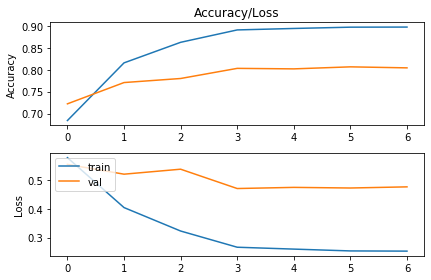

In [0]:
#collapse-hide
albert_squad = Albert(**config_squad)

albert_squad.finetune()

## Finetune using our labeled dataset

Ok we have finetuned `Albert` to pick out the positive and negative sentiments movie reviews. Finally, we will finetune `Albert` for our use case using the following configurations. The **eighth epoch** gave the best run with the lowest loss (0.4546).

In [0]:
#collapse-hide
config_summaries = {
    "albert_config": "albert-base-v2",
    "task": "sst-2",
    "max_seq_length": 128,
    "buffer_size": 128,
    "batch_size": 36,
    "test_size": 0.3,
    "random_state": 42,
    "load_weights_path": "./model/squad-weights-improvement-04.ckpt",
    "lr": 5e-5,
    "reduce_lr_factor": 0.1,
    "lr_patience": 2,
    "early_stop_patience": 5,
    "num_epochs": 20,
    "min_lr": 5e-9,
    "train_data_path": "./data/Wiki/train.tsv",
    "dev_data_path": "./data/Wiki/dev.tsv",
    "col_num_text_a": 0,
    "col_num_label": 1,
    "checkpoint_save_path": "./model/summary-weights-improvement-{epoch:02d}.ckpt"
}

model initiated!
dataset loaded!
Train for 10 steps, validate for 3 steps
Epoch 1/20
 9/10 [==========================>...] - ETA: 2s - loss: 0.6752 - accuracy: 0.7068
Epoch 00001: val_loss improved from inf to 0.70040, saving model to ./model/summary-weights-improvement-01.ckpt
10/10 [==============================] - 30s 3s/step - loss: 0.6479 - accuracy: 0.7306 - val_loss: 0.7004 - val_accuracy: 0.6204
Epoch 2/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.5817 - accuracy: 0.7081
Epoch 00002: val_loss improved from 0.70040 to 0.57846, saving model to ./model/summary-weights-improvement-02.ckpt
10/10 [==============================] - 7s 661ms/step - loss: 0.5813 - accuracy: 0.7095 - val_loss: 0.5785 - val_accuracy: 0.7778
Epoch 3/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.3281 - accuracy: 0.8975
Epoch 00003: val_loss did not improve from 0.57846
10/10 [==============================] - 6s 600ms/step - loss: 0.3277 - accuracy: 0.8883 - val_loss: 0.95

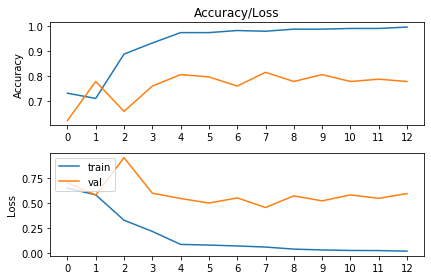

In [0]:
#collapse-hide
albert_summaries = Albert(**config_summaries)

albert_summaries.finetune()

# Predict Sentiment

![](my_icons/geopolitical_mapper/crystal_ball.JPG)

With the model finetuned with our labeled dataset, we can use it to come up with sentiment predictions. **The sentences need to be encoded** before feeding it into the model to obtain the logits `logit = albert_summaries.embed(encoded_s)[0]`. We will then place the logits through a **softmax function** `_get_proba` to obtain the probabilities that the sentiments are negative or positive.

In [0]:
#collapse-hide
def _get_proba(logit):
    """
    Helper function for get_predictions_probas
    Computes softmax values based on logit

    args:
    ------
        logit: (float) logit output of finetuned ALBERT model
    Return:
    ------
        softmax values representing the sentiment probabilities
    """

    return np.exp(logit) / np.sum(np.exp(logit), axis=1)

In [0]:
#collapse-hide
def get_predictions_probas(summaries, config, weights_path):
    """
    Returns the sentiment probabilities (positive or negative sentiments)
    for the wiki summary sentences

    args:
    ------
        summaries: (list) wiki summary sentences that require sentiment predictions
        config: (dict) chosen configuration for the ALBERT model
        weights_path: (str) path leading to the weights of the finetuned
                      ALBERT model
    Return:
    ------
        sentiment_preds: (list) sentiment predictions for the wiki summary sentences

    """

    albert_summaries = Albert(**config)
    albert_summaries.restore(weights_path)

    sentiment_probas = []
    for i, s in enumerate(summaries):

      encoded_s = albert_summaries.tokenizer.encode_plus(s,
                                                        text_pair=None,
                                                        max_length=albert_summaries.max_seq_length,
                                                        pad_to_max_length=True,
                                                        add_special_tokens=True,
                                                        return_tensors="tf")
    
      logit = albert_summaries.embed(encoded_s)[0]
      pred = _get_proba(logit)
      sentiment_probas.append(pred[:,1][0])

    return sentiment_probas

In [0]:
#collapse-hide
%%capture

sent_ld_df = pd.read_csv('./data/Wiki/sent_ld.csv')
sent_ul_df = pd.read_csv('./data/Wiki/sent_ul.csv')

sent_all_df = pd.concat([sent_ld_df, sent_ul_df], axis=0)

summaries = sent_all_df['Summary_Sentence'].tolist()

sentiment_probas = get_predictions_probas(summaries, config_summaries,
                                          './model/summary-weights-improvement-08.ckpt')

sent_all_df['Predictions_Probas'] = sentiment_probas

And here we have the sentiment probabilities for the sentences! Sentences with probabilities that are **closer to 1** are considered to have **positive sentiments**.

In [0]:
#collapse-hide
sent_all_df[['Country_Pair', 'Label', 'Summary_Sentence', 'Predictions_Probas']].head(5)

,Country_Pair,Label,Summary_Sentence,Predictions_Probas
0,China_Indonesia,1.0,The relations between two nations have been on...,0.279244
1,China_Indonesia,0.0,"However, the diplomatic relationship between t...",0.052571
2,China_Indonesia,1.0,China has an embassy in Jakarta and consulates...,0.990907
3,China_Indonesia,2.0,Both countries are among the largest nations i...,0.990101
4,China_Indonesia,1.0,Both nations are the members of APEC and G-20 ...,0.985640


# How did we do? On to the results!

![](my_icons/geopolitical_mapper/excited_baby.JPG)

To be honest, I do not know how the results will turn out at this point given that the dataset that we were using was self-generated and manually labeled. On a positive note, it appears that the model was able to predict some of the sentiments correctly. 

### Correctly classified relationships

In [0]:
#collapse-hide
# Sentences
print(sent_all_df[sent_all_df['Country_Pair'] == 'China_Singapore']['Summary_Sentence'].tolist())

# Sentiment probabilities
sent_all_df[sent_all_df['Country_Pair'] == 'China_Singapore']['Predictions_Probas'].tolist()

["People's Republic of China – Singapore relations officially started on 3 October 1990.", 'Diplomatic missions were established in the early 1990s based on trade and the warming of ties from other ASEAN countries towards mainland China.', 'Singapore and China have maintained a long-standing and greatly prioritised close relationship, and partly because of the latter\'s growing influence and essentiality in the Asia-Pacific region, specifying that "its common interest with China is far greater than any differences".', "Furthermore, Singapore has positioned itself as a strong supporter for China's constructive engagement and peaceful development in the region.", "It has engaged co-operation with other ASEAN members and China to strengthen regional security and fight terrorism, while participating in the organisation's first maritime exercise with the latter.", "While relationship between the two countries stand strong, differences were experienced during numerous high-profile events, in

[0.9891862273216248,
 0.98930823802948,
 0.9773917198181152,
 0.990622878074646,
 0.9888237714767456,
 0.9899033308029175,
 0.9854150414466858]

In [0]:
#collapse-hide
# Sentences
print(sent_all_df[sent_all_df['Country_Pair'] == 'Russia_United States']['Summary_Sentence'].tolist()[0:4])

# Sentiment probabilities
sent_all_df[sent_all_df['Country_Pair'] == 'Russia_United States']['Predictions_Probas'].tolist()[0:4]

['The United States and Russia maintain diplomatic and trade relations.', 'The relationship was generally warm under the Russian President Boris Yeltsin (1991–99) until the NATO bombing of the Federal Republic of Yugoslavia in the spring of 1999, and has since deteriorated significantly.', "In 2014, relations greatly deteriorated further due to the crisis in Ukraine, Russia's annexation of Crimea in 2014, differences regarding Russian military intervention in the Syrian Civil War, and from the end of 2016 over Russia's alleged interference in the 2016 U.S. elections.", 'Mutual sanctions imposed in 2014 remain in place.']


[0.9242598414421082,
 0.9835892915725708,
 0.01635131798684597,
 0.013922506012022495]

### Incorrectly classified relationships

In [0]:
#collapse-hide
# Sentences
print(sent_all_df[sent_all_df['Country_Pair'] == 'China_United States']['Summary_Sentence'].tail(5).tolist())

# Sentiment probabilities
sent_all_df[sent_all_df['Country_Pair'] == 'China_United States']['Predictions_Probas'].tail(5).tolist()

["Despite tensions during his term, the Chinese population's favorability of the U.S. stood at 51% in Obama's last year of 2016, only to dip during the Trump Administration.", 'The relations deteriorated sharply under President Donald Trump, whose administration launched a trade war against China, banned US companies from selling equipment to Huawei, increased visa restrictions on Chinese nationality students and scholars and designated China as a "currency manipulator".', 'During the Trump administration, and especially since the US-China trade war began, political observers have started to warn that a new cold war is emerging.', 'Michael D. Swaine warned in 2019, "The often positive and optimistic forces, interests, and beliefs that sustained bilateral ties for decades are giving way to undue pessimism, hostility, and a zero-sum mindset in almost every area of engagement."', 'However by 2020, the two countries have started to take steps in order to repair the relations; U.S. lifted i

[0.17708182334899902,
 0.7658159732818604,
 0.10857371240854263,
 0.7851555347442627,
 0.1416555643081665]

Our model can definitely do better! It will be great if we could have more training data if time permits!

# Visualizing our predictions!

![](my_icons/geopolitical_mapper/visualization.JPG)

Our aim in this section is for us to visualize the sentiments on a world map plot. We will allow a user to select a country to focus on. And the sentiments of its relationships with other countries will be displayed on the plot.

By default we will **allow the user to choose a country from column `Country_A`**. Currently our dataframe of predictions comprises of **one-directional relationships**. For example, if United States - China was represented in the dataframe, the China - United States relationship would be missing. Let's **stack** the dataframe we have currently, with another dataframe where the names in columns `Country_A` and `Country_B` are swapped.

### Creating a stacked dataframe

Great! Now all of our relationships are represented!

In [0]:
#collapse-hide
sent_all_swap_df = sent_all_df.copy()
sent_all_swap_df['Country_A'] = sent_all_df['Country_B']
sent_all_swap_df['Country_B'] = sent_all_df['Country_A']

sent_all_stack_df = pd.concat([sent_all_df, sent_all_swap_df], axis=0)
sent_all_stack_df.sort_values(by='Country_A', ascending=False)

sent_all_stack_df[sent_all_stack_df['Country_Pair'].str.contains('China_United States')]

,Country_A,Country_B,Country_Pair,Label,Summary_Sentence,Predictions_Probas
2436,China,United States,China_United States,NaN,China–United States relations (simplified Chin...,0.651927
2437,China,United States,China_United States,NaN,The history of the relationship can be traced ...,0.987907
2438,China,United States,China_United States,NaN,The relationship between the two countries hav...,0.985974
2439,China,United States,China_United States,NaN,Both countries used to have an extremely exten...,0.517934
2440,China,United States,China_United States,NaN,"It is a relationship of economic cooperation, ...",0.399313
...,...,...,...,...,...,...
6048,United States,China,China_United States,NaN,"Despite tensions during his term, the Chinese ...",0.177082
6049,United States,China,China_United States,NaN,The relations deteriorated sharply under Presi...,0.765816
6050,United States,China,China_United States,NaN,"During the Trump administration, and especiall...",0.108574
6051,United States,China,China_United States,NaN,"Michael D. Swaine warned in 2019, ""The often p...",0.785156


### Calculating the average sentiment score



As we have calculated the sentiment score at a sentence level,we will use pandas' `groupby` to **average the sentiment score** for each country pair.

In [0]:
#collapse-hide
sent_all_stack_df.groupby('Country_Pair').mean()['Predictions_Probas']

Country_Pair
Abkhazia_Nauru           0.938478
Abkhazia_Nicaragua       0.757214
Abkhazia_Tuvalu          0.961020
Abkhazia_Vanuatu         0.523380
Afghanistan_China        0.813562
                           ...   
United States_Vietnam    0.910205
United States_Yemen      0.086554
United States_Zambia     0.740769
Yemen_European Union     0.984979
Zambia_Zimbabwe          0.635722
Name: Predictions_Probas, Length: 1171, dtype: float64

### Retrieving the ISO code for each country

Plotly, the visualization package that we will be using, **identifies each country's location on the world map by using the ISO code.** We can easily retrieve the ISO codes in the form of a txt file from the web. However, once again, the names of the countries used in the ISO codes txt file might be different from what we have in the dataframe. 

Fret not! `get_std_names` is here to save the day. We will map the names of the countries in the txt file to obtain its standardized `std` names.

In [0]:
#collapse-hide
country_ISO_raw_df = pd.read_csv('./data/Wiki/country_ISO.txt', sep="  ",
                                 header=None, names=['ISO_Code', 'Country'])

country_ISO_df = get_std_names(country_ISO_raw_df,
                               'Country', alt_names_to_countries)

country_ISO_df.sort_values(by=['Country']).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,ISO_Code,Country,Country_Std
1,AFG,Afghanistan,afghanistan
5,ALB,Albania,albania
64,DZA,Algeria,algeria
10,ASM,American Samoa,american_samoa
6,AND,Andorra,andorra
2,AGO,Angola,angola
3,AIA,Anguilla,anguilla
11,ATA,Antarctica,antarctica
13,ATG,Antigua and Barbuda,antigua_and_barbuda
8,ARG,Argentina,argentina


We will convert the dataframe into a dictionary for faster mappings.

In [0]:
#collapse-hide
country_to_ISO = {k:v for k,v in zip(country_ISO_df['Country_Std'], \
                                     country_ISO_df['ISO_Code'])}

Let's create an additional column in our `sent_all_stack_df` to populate the ISO codes of the countries.

In [0]:
#collapse-hide
def get_ISO(country):
  try:
    ISO = country_to_ISO[country]
  except:
    ISO = 'Not Available'

  return ISO

In [0]:
#collapse-hide
sent_all_stack_df = get_std_names(sent_all_stack_df, 'Country_A', \
                                  alt_names_to_countries)

sent_all_stack_df = get_std_names(sent_all_stack_df, 'Country_B', \
                                  alt_names_to_countries)

sent_all_stack_df['country_A_ISO'] = sent_all_stack_df['Country_A_Std'].apply(get_ISO)
sent_all_stack_df['country_B_ISO'] = sent_all_stack_df['Country_B_Std'].apply(get_ISO)

We will exclude countries with no ISO codes for now.

In [0]:
#collapse-hide
sent_all_stack_avail_df = sent_all_stack_df[sent_all_stack_df['country_A_ISO'] != 'Not Available']

# Time to visualize the sentiments!

![](my_icons/geopolitical_mapper/finally_over_obama.JPG)

Here are countries that we can choose from.

In [0]:
#collapse-hide
np.sort(sent_all_stack_avail_df['Country_A_Std'].unique())

array(['afghanistan', 'albania', 'algeria', 'andorra', 'angola',
       'antigua_and_barbuda', 'argentina', 'armenia', 'australia',
       'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh',
       'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bhutan',
       'bolivia', 'bosnia_and_herzegovina', 'botswana', 'brazil',
       'bulgaria', 'burkina_faso', 'burundi', 'cambodia', 'cameroon',
       'canada', 'cape_verde', 'central_african_republic', 'chad',
       'chile', 'china', 'colombia', 'comoros', 'costa_rica', 'croatia',
       'cuba', 'cyprus', 'czech_republic', 'denmark', 'djibouti',
       'dominica', 'dominican_republic', 'east_timor', 'ecuador', 'egypt',
       'el_salvador', 'equatorial_guinea', 'eritrea', 'estonia',
       'eswatini', 'ethiopia', 'fiji', 'finland', 'france', 'gabon',
       'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada',
       'guatemala', 'guinea-bissau', 'guyana', 'haiti', 'holy_see',
       'honduras', 'hungary', 'iceland', '

For illustration purposes, let's select **"united_states"**

In [0]:
#collapse-hide
country = "united_states"
sent_country_df = sent_all_stack_avail_df[sent_all_stack_avail_df['Country_A_Std'] == country]

With the help of Plotly, we are able to illustrate the sentiments on a world map.

In [0]:
# https://plot.ly/python/bubble-maps/

import plotly.express as px
fig = px.scatter_geo(sent_country_df,
                     locations="country_B_ISO",
                     color="Predictions_Probas",
                     hover_name="Country_B_Std",
                     projection="natural earth")

# To show smaller countries
fig.update_layout({
    'geo': {
        'resolution': 50
    }
})


fig.show()

# Future improvements

ALBERT is indeed a very impressive language model. I'm looking forward to replicate the success `Albert` has on the Wikipedia dataset to news headlines scrapped from the web. However, there are added layers of complexity that needs to be solved:

* As explained earlier, we need to be able to differentiate facts from commentaries.

* A simple Googling of "United States - China" relations might not return results that are all relevant. An added element of effort needs to be put in to clean the dataset.

Like any data scientist would do, a deeper analysis of the results can be conducted by analysing the precision/recall on the test dataset.

That's it for now folks! If you have any questions/comments please feel free to reach out to me through [Linkedin](https://www.linkedin.com/in/kennethwangtm/) or email at ken.wangtm@gmail.com